<a href="https://colab.research.google.com/github/rolandoteniya/sp500-volatility-forecasting/blob/main/S%26P500_Volatility_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Initialisation & Dependency Management

This section handles the installation of specialised econometric and interpretability libraries, alongside the centralised management of dependencies. Global random seeds are initialized here to ensure the reproducibility of neural network weights and statistical test results.

In [1]:
!pip install -q arch
!pip install -q shap
!pip install -q dieboldmariano

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import tensorflow as tf
import shap
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import math
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
from dieboldmariano import dm_test
import random
from IPython.core import page
page.page = lambda msg: None

#2025-07-27 end date

np.random.seed(11)
tf.random.set_seed(11)
random.seed(11)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 15.0 MB/s eta 0:00:00


###2. Data Acquisition & Pre-processing

This section automates the retrieval of historical S&P 500 and VIX data using the Yahoo Finance API. Raw prices are converted into logarithmic returns to ensure the time series is better suited for statistical modeling and neural network training.

In [2]:
# --- PART 1: DATA ACQUISITION AND PREPARATION ---
# # 1.1 Downloading S&P 500 Close Price and VIX Close Price. Working out Log Returns of S&P 500.

sp500 = yf.download(tickers="^GSPC", start="1999-12-02", end='2025-07-27')
vix = yf.download(tickers="^VIX", start="1999-12-02", end='2025-07-27')

close_sp500 = sp500['Close']
close_vix = vix['Close']

sp500_logrtn = np.log(close_sp500 / close_sp500.shift(1))
sp500_logrtn = sp500_logrtn.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


###3. Exploratory Data Analysis (EDA): Volatility Dynamics

Visualising price trends and sentiment indices establishes the necessary context for understanding market regimes. To ensure statistical rigor, we complement this with a stationarity analysis of the log returns using rolling windows and the Augmented Dickey-Fuller (ADF) test, validating that the series maintains the constant mean and variance required for robust volatility forecasting.

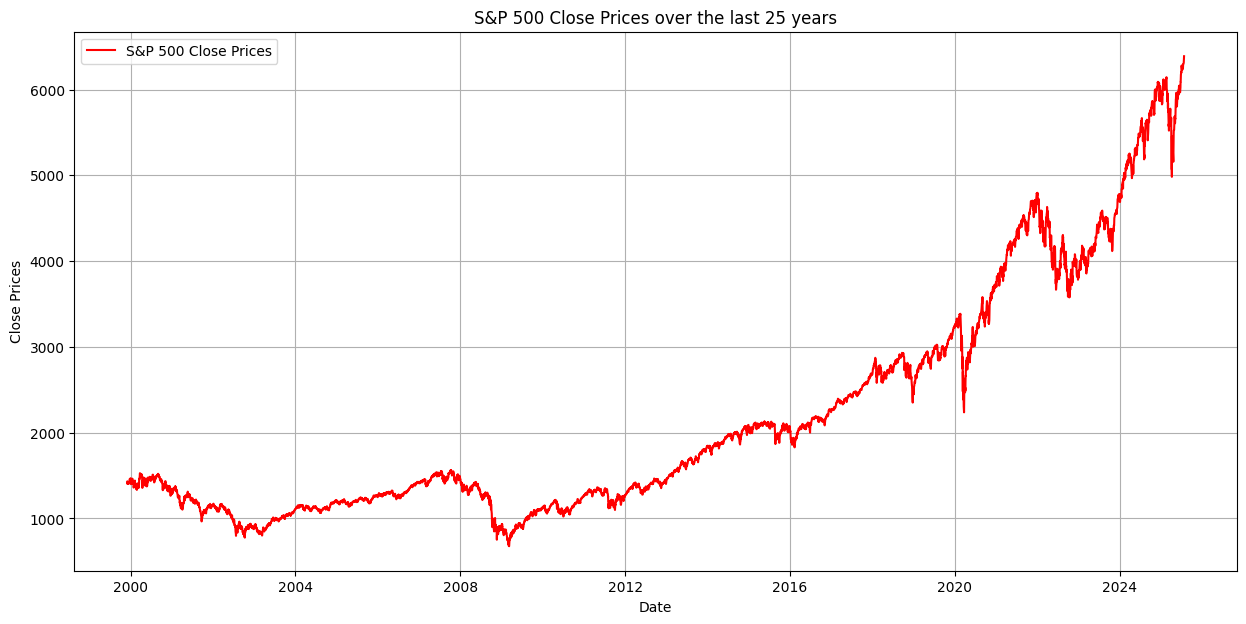

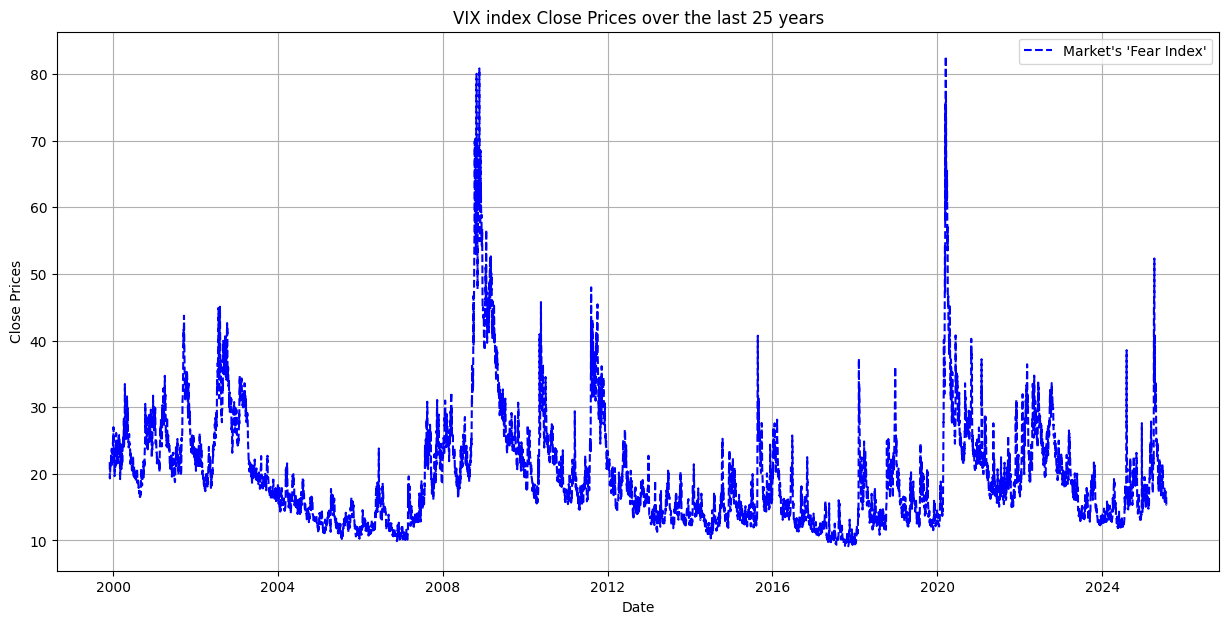

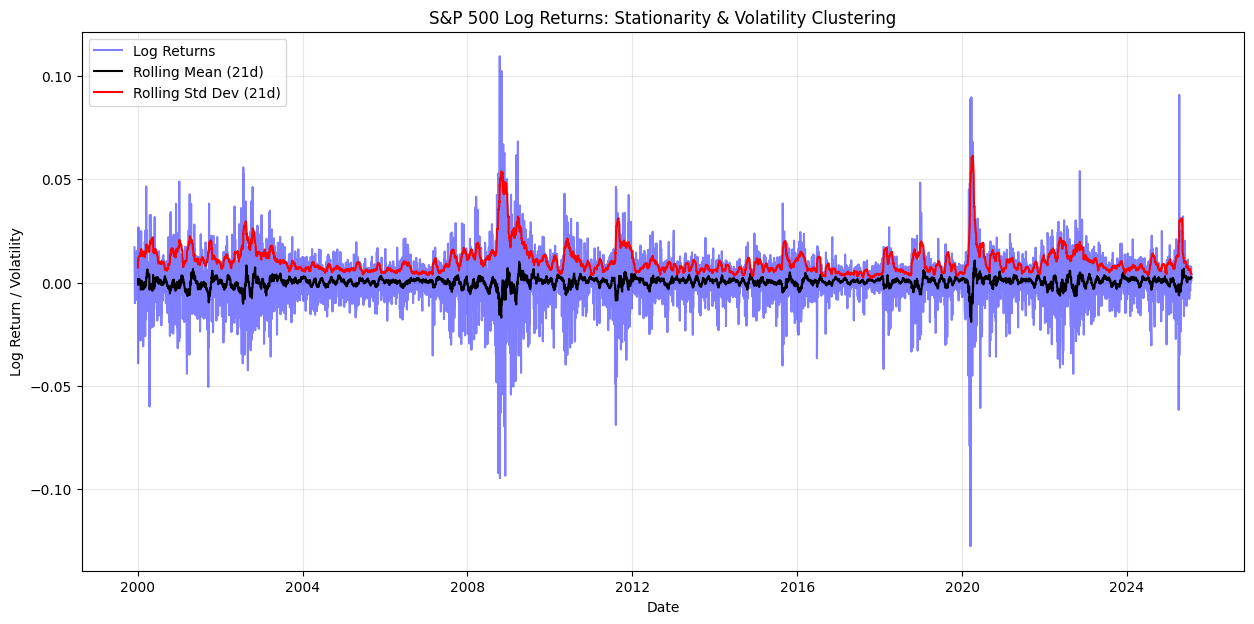

ADF Statistic: -19.277279230440175
p-value: 0.0


In [3]:
## Plot of the S&P 500 price and VIX ("Fear Index")
plt.figure(figsize=(15,7))
plt.plot(close_sp500, label='S&P 500 Close Prices', color='red')
plt.title('S&P 500 Close Prices over the last 25 years')
plt.ylabel('Close Prices')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,7))
plt.plot(close_vix, label="Market's 'Fear Index'", color='blue', linestyle='--')
plt.title('VIX index Close Prices over the last 25 years')
plt.ylabel('Close Prices')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# STATIONARITY VISUALISATION
# Calculate rolling statistics (21-day window represents roughly one trading month)
rolling_mean = sp500_logrtn.rolling(window=21).mean()
rolling_std = sp500_logrtn.rolling(window=21).std()

# Plotting the log returns and rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(sp500_logrtn, color='blue', label='Log Returns', alpha=0.5)
plt.plot(rolling_mean, color='black', label='Rolling Mean (21d)')
plt.plot(rolling_std, color='red', label='Rolling Std Dev (21d)')

plt.title('S&P 500 Log Returns: Stationarity & Volatility Clustering')
plt.xlabel('Date')
plt.ylabel('Log Return / Volatility')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

#Verify Stationarity with ADF Test

"""
Performs the Augmented Dickey-Fuller (ADF) test on the log return series.
If p-value < 0.05 then the data is stationary. (constant mean and variance)
"""
adf_result = adfuller(sp500_logrtn)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

###4. Target Variable Egnineering & Chronological Data Partitioning

This section defines the model's target variable by calculating the annualized realized volatility over a 21-day forward-looking horizon. A strict chronological split is then implemented to partition the data into training, validation, and testing sets, ensuring the models are evaluated on unseen future data without the risk of look-ahead bias.

In [4]:
## 1.4 Generate Target Variable & Final DataFrame

"""
This calculates future realised volatility, this will be the ground truth.
"""

future_volatility = sp500_logrtn.shift(-21).rolling(window=21).std() * (252**0.5)
future_volatility = future_volatility.dropna()

aligned_data = pd.concat([sp500_logrtn, close_vix, future_volatility], axis=1, join='inner')
aligned_data.columns = ['sp500 log rtns', 'close vix', 'future volatility']

#print(aligned_data.head())

## 1.5 Split Data into Training, Validation, and Test Sets
# Calculate the split points
split1 = int(len(aligned_data) * 0.7)
split2 = int(len(aligned_data) * 0.85)

# Perform the chronological split
train_data = aligned_data.iloc[:split1]
val_data = aligned_data.iloc[split1:split2]
test_data = aligned_data.iloc[split2:]

# Extract the log return series for convenience
returns_train = train_data['sp500 log rtns']
returns_val = val_data['sp500 log rtns']
returns_test = test_data['sp500 log rtns']

###5. Establishing the Econometric Baseline: ARCH Family Models

This section implements a suite of traditional econometric models—ranging from basic ARCH to asymmetric variants like EGARCH and APARCH—to establish a robust statistical baseline. These models serve as the benchmark for evaluating the predictive uplift provided by the subsequent Deep Learning and hybrid architectures.

In [5]:
# --- PART 2: MODEL DEVELOPMENT AND SELECTION (VALIDATION SET) ---
## 2.1 Econometric Models

### ARCH(1) Model
arch_model_spec = arch_model(returns_train, vol='ARCH', q=1)
arch_results = arch_model_spec.fit(disp='off')

arch_forecast = arch_results.forecast(horizon=len(val_data))
predicted_variance = arch_forecast.variance.iloc[0].values
actual_volatility = val_data['future volatility'].values
rmse_arch = np.sqrt(mean_squared_error(actual_volatility, np.sqrt(predicted_variance)))

print(f'ARCH(1) RMSE: {rmse_arch}')
#print(arch_results.summary())


### GARCH(1,1) Model
garch_model = arch_model(returns_train, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(disp='off')

garch_forecast = garch_results.forecast(horizon=len(val_data))
predicted_variance = garch_forecast.variance.iloc[0].values
actual_volatility = val_data['future volatility'].values
rmse_garch = np.sqrt(mean_squared_error(actual_volatility, np.sqrt(predicted_variance)))

print(f'GARCH(1,1) RMSE: {rmse_garch}')
#print(garch_results.summary())


### EGARCH(1,1) Model
egarch_model = arch_model(returns_train, vol="EGARCH",p=1, o=1, q=1)
egarch_results = egarch_model.fit(disp='off')

egarch_forecast = egarch_results.forecast(horizon=len(val_data), method="simulation")
predicted_variance = egarch_forecast.variance.iloc[0].values
actual_volatility = val_data['future volatility'].values
rmse_egarch = np.sqrt(mean_squared_error(actual_volatility, np.sqrt(predicted_variance)))

print(f'EGARCH(1,1) RMSE: {rmse_egarch}')
#print(egarch_results.summary())

### GJR-GARCH(1,1) Model
gjr_model = arch_model(returns_train, vol='GARCH', p=1, o=1, q=1)
gjr_results = gjr_model.fit(disp='off')

gjr_forecast = gjr_results.forecast(horizon=len(val_data))
predicted_variance = gjr_forecast.variance.iloc[0].values
actual_volatility = val_data['future volatility'].values
rmse_gjr = np.sqrt(mean_squared_error(actual_volatility, np.sqrt(predicted_variance)))

print(f'GJR-GARCH(1,1) RMSE: {rmse_gjr}')
#print(gjr_results.summary())


### APARCH(1,1) Model
aparch_model = arch_model(returns_train, vol='APARCH', p=1, o=1, q=1)
aparch_results = aparch_model.fit(disp='off')
aparch_residuals = aparch_results.resid / aparch_results.conditional_volatility


# Generate a reproducible forecast
rs = np.random.RandomState(11)
aparch_forecast = aparch_results.forecast(horizon=len(val_data), method='simulation', simulations=1000, rng=rs.standard_normal)

# Extract predictions and calculate RMSE
predicted_variance_aparch = aparch_forecast.variance.iloc[0].values
actual_volatility = val_data['future volatility'].values
rmse_aparch = np.sqrt(mean_squared_error(actual_volatility, np.sqrt(predicted_variance_aparch)))

print(f'APARCH(1,1) RMSE: {rmse_aparch}')
#print(aparch_results.summary())

ARCH(1) RMSE: 0.20681776838539404
GARCH(1,1) RMSE: 0.2018375339600817
EGARCH(1,1) RMSE: 0.20767770013076425
GJR-GARCH(1,1) RMSE: 0.9828100079643775


/tmp/ipython-input-2568546168.py:44: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  gjr_results = gjr_model.fit(disp='off')


APARCH(1,1) RMSE: 0.16292155862282204


### 6. Deep Learning Architectures: Standalone and VIX-Enhanced LSTMs

This section implements Long Short-Term Memory (LSTM) networks to capture the non-linear temporal dependencies inherent in financial volatility. I compare a univariate model using only historical log returns against a multivariate version that incorporates the VIX index to assess the predictive uplift provided by market sentiment data.

In [15]:
## 2.2 Deep Learning Models

### Standalone LSTM Model
# Prepare Training Data
sequence_length = 60
train_features = returns_train.values.reshape(-1,1)
train_target = train_data['future volatility'].values
scaler = MinMaxScaler(feature_range=(0,1))
train_features_scaled = scaler.fit_transform(train_features)
x_train, y_train = [],[]
for i in range(sequence_length, len(train_features_scaled)):
  x_train.append(train_features_scaled[i-sequence_length:i, 0])
  y_train.append(train_target[i])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare Validation Data
val_features = val_data['sp500 log rtns'].values.reshape(-1,1)
actual_volatility = val_data['future volatility'].values
val_features_scaled = scaler.transform(val_features)
x_val, y_val = [], []
for i in range(sequence_length, len(val_features_scaled)):
  x_val.append(val_features_scaled[i-sequence_length: i, 0])
  y_val.append(actual_volatility[i])
x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Build, Train, and Evaluate the Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

history = lstm_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val), verbose=0)

lstm_predictions = lstm_model.predict(x_val)
rmse_lstm = np.sqrt(mean_squared_error(y_val, lstm_predictions))

print(f'Standalone LSTM RMSE: {rmse_lstm}')



### VIX-Enhanced LSTM Model
# Prepare Training Data
train_features_vix = train_data[['sp500 log rtns', 'close vix']]
scaler_vix = MinMaxScaler(feature_range=(0, 1))
train_features_vix_scaled = scaler_vix.fit_transform(train_features_vix)
train_target = train_data['future volatility'].values
x_train_vix, y_train_vix = [],[]
for i in range(sequence_length, len(train_features_vix_scaled)):
  x_train_vix.append(train_features_vix_scaled[i-sequence_length:i, :])
  y_train_vix.append(train_target[i])
x_train_vix, y_train_vix = np.array(x_train_vix), np.array(y_train_vix)

# Prepare Validation Data
val_features_vix = val_data[['sp500 log rtns', 'close vix']]
val_features_vix_scaled = scaler_vix.transform(val_features_vix)
actual_volatility = val_data['future volatility'].values
x_val_vix, y_val_vix = [], []
for i in range(sequence_length, len(val_features_vix_scaled)):
  x_val_vix.append(val_features_vix_scaled[i-sequence_length: i, :])
  y_val_vix.append(actual_volatility[i])
x_val_vix, y_val_vix = np.array(x_val_vix), np.array(y_val_vix)

# Build, Train, and Evaluate the Model
lstm_vix_model = Sequential()
lstm_vix_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_vix.shape[1], 2)))
lstm_vix_model.add(Dropout(0.2))
lstm_vix_model.add(LSTM(units=50, return_sequences=False))
lstm_vix_model.add(Dropout(0.2))
lstm_vix_model.add(Dense(units=25))
lstm_vix_model.add(Dense(units=1))

lstm_vix_model.compile(optimizer='adam', loss='mean_squared_error')

history_vix = lstm_vix_model.fit(x_train_vix, y_train_vix, epochs=25, batch_size=32, validation_data=(x_val_vix, y_val_vix), verbose=0)

lstm_vix_predictions = lstm_vix_model.predict(x_val_vix)
rmse_lstm_vix = np.sqrt(mean_squared_error(y_val_vix, lstm_vix_predictions))

print(f'VIX-Enhanced LSTM RMSE: {rmse_lstm_vix}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Standalone LSTM RMSE: 0.1353903262396069
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
VIX-Enhanced LSTM RMSE: 0.13021284765694618


### 7. Hybrid APARCH-LSTM Architectures

This stage explores hybrid modeling by ensembling the statistical residuals from the APARCH baseline (best performing econometric model) with the LSTM's ability to map complex relationships. These multi-feature architectures represent the peak of the model 'bake-off,' testing whether combining econometric rigor with Deep Learning produces a superior forecast.

In [16]:
### APARCH-LSTM (Residuals + Log Returns)
# Prepare Training Data
hybrid_features_train = train_data[['sp500 log rtns']].copy()
hybrid_features_train['residuals'] = aparch_residuals
scaler_hybrid = MinMaxScaler(feature_range=(0, 1))
hybrid_features_train_scaled = scaler_hybrid.fit_transform(hybrid_features_train)
train_target = train_data['future volatility'].values
x_train_hy, y_train_hy = [], []
for i in range(sequence_length, len(hybrid_features_train_scaled)):
  x_train_hy.append(hybrid_features_train_scaled[i-sequence_length:i, :])
  y_train_hy.append(train_target[i])
x_train_hy, y_train_hy = np.array(x_train_hy), np.array(y_train_hy)

# Prepare Validation Data
rs = np.random.RandomState(11)
aparch_forecast_val = aparch_results.forecast(horizon=len(val_data), method='simulation',rng=rs.standard_normal)
predicted_variance_val = aparch_forecast_val.variance.iloc[0].values
actual_returns_val = val_data['sp500 log rtns'].values
mean_forecast_val = aparch_results.params['mu']
residuals_val = actual_returns_val - mean_forecast_val
standardized_residuals_val = residuals_val / np.sqrt(predicted_variance_val)
hybrid_features_val = val_data[['sp500 log rtns']].copy()
hybrid_features_val['residuals'] = standardized_residuals_val
hybrid_features_val_scaled = scaler_hybrid.transform(hybrid_features_val)
x_val_hy, y_val_hy = [], []
for i in range(sequence_length, len(hybrid_features_val_scaled)):
  x_val_hy.append(hybrid_features_val_scaled[i-sequence_length:i, :])
  y_val_hy.append(val_data['future volatility'].values[i])
x_val_hy, y_val_hy = np.array(x_val_hy), np.array(y_val_hy)

# Build, Train, and Evaluate the Model
np.random.seed(11)
tf.random.set_seed(11)
random.seed(11)
lstm_hy = Sequential()
lstm_hy.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_hy.shape[1], 2)))
lstm_hy.add(Dropout(0.2))
lstm_hy.add(LSTM(units=50, return_sequences=False))
lstm_hy.add(Dropout(0.2))
lstm_hy.add(Dense(units=25))
lstm_hy.add(Dense(units=1))

lstm_hy.compile(optimizer='adam', loss='mean_squared_error')

history_hy = lstm_hy.fit(x_train_hy, y_train_hy, epochs=25, batch_size=32, validation_data=(x_val_hy, y_val_hy), verbose=0)

lstm_hy_predictions = lstm_hy.predict(x_val_hy)
rmse_lstm_hy = np.sqrt(mean_squared_error(y_val_hy, lstm_hy_predictions))

print(f'APARCH-LSTM (Residuals + Log Returns) RMSE: {rmse_lstm_hy}')


### APARCH-VIX-LSTM (Residuals + Log Returns + VIX)
# Prepare Training Data
hybrid_vix_features_train = train_data[['sp500 log rtns', 'close vix']].copy()
hybrid_vix_features_train['residuals'] = aparch_residuals
scaler_vix_hybrid = MinMaxScaler(feature_range=(0,1))
hybrid_vix_features_train_scaled = scaler_vix_hybrid.fit_transform(hybrid_vix_features_train)
train_target = train_data['future volatility'].values
x_train_vix_hy, y_train_vix_hy = [],[]
for i in range(sequence_length, len(hybrid_vix_features_train_scaled)):
  x_train_vix_hy.append(hybrid_vix_features_train_scaled[i-sequence_length:i, :])
  y_train_vix_hy.append(train_target[i])
x_train_vix_hy, y_train_vix_hy = np.array(x_train_vix_hy), np.array(y_train_vix_hy)

# Prepare Validation Data
rs = np.random.RandomState(11)
aparch_forecast_val = aparch_results.forecast(horizon=len(val_data), method='simulation',rng=rs.standard_normal)
predicted_variance_val = aparch_forecast_val.variance.iloc[0].values
actual_returns_val = val_data['sp500 log rtns'].values
mean_forecast_val = aparch_results.params['mu']
residuals_val = actual_returns_val - mean_forecast_val
standardized_residuals_val = residuals_val / np.sqrt(predicted_variance_val)
hybrid_vix_features_val = val_data[['sp500 log rtns', 'close vix']].copy()
hybrid_vix_features_val['residuals'] = standardized_residuals_val
hybrid_vix_features_val_scaled = scaler_vix_hybrid.transform(hybrid_vix_features_val)
x_val_vix_hy, y_val_vix_hy = [], []
for i in range(sequence_length, len(hybrid_vix_features_val_scaled)):
  x_val_vix_hy.append(hybrid_vix_features_val_scaled[i-sequence_length:i, :])
  y_val_vix_hy.append(val_data['future volatility'].values[i])
x_val_vix_hy, y_val_vix_hy = np.array(x_val_vix_hy), np.array(y_val_vix_hy)

# Build, Train, and Evaluate the Model
np.random.seed(11)
tf.random.set_seed(11)
random.seed(11)
lstm_vix_hy = Sequential()
lstm_vix_hy.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_vix_hy.shape[1], 3)))
lstm_vix_hy.add(Dropout(0.2))
lstm_vix_hy.add(LSTM(units=50, return_sequences=False))
lstm_vix_hy.add(Dropout(0.2))
lstm_vix_hy.add(Dense(units=25))
lstm_vix_hy.add(Dense(units=1))

lstm_vix_hy.compile(optimizer='adam', loss='mean_squared_error')

history_vix_hy = lstm_vix_hy.fit(x_train_vix_hy, y_train_vix_hy, epochs=25, batch_size=32, validation_data=(x_val_vix_hy, y_val_vix_hy), verbose=0)

lstm_vix_hy_predictions = lstm_vix_hy.predict(x_val_vix_hy)
rmse_lstm_vix_hy = np.sqrt(mean_squared_error(y_val_vix_hy, lstm_vix_hy_predictions))

print(f'APARCH-VIX-LSTM (3-Feature Hybrid) RMSE: {rmse_lstm_vix_hy}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
APARCH-LSTM (Residuals + Log Returns) RMSE: 0.13999693682588654
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
APARCH-VIX-LSTM (3-Feature Hybrid) RMSE: 0.1275107756034547


### 8. Performance Evaluation

This section aggregates the RMSE for all nine models into a summary table. Sorting these results allows to rank the architectures, identifying the most effective models for capturing S&P 500 volatility before final evaluation on the out-of-sample test set.

In [8]:
## 2.4 Validation Set Results Summary

#Dictionary with all models names and their final RMSE scores
validation_results = {
    'Model':[
        'ARCH',
        'GARCH',
        'EGARCH',
        'GJR-GARCH',
        'APARCH',
        'LSTM',
        'LSTM-VIX',
        'APARCH-LSTM',
        'APARCH-VIX-LSTM',
    ],
    'Validation RMSE': [
        rmse_arch,
        rmse_garch,
        rmse_egarch,
        rmse_gjr,
        rmse_aparch,
        rmse_lstm,
        rmse_lstm_vix,
        rmse_lstm_hy,
        rmse_lstm_vix_hy,
    ]
}

# Convert the dictionary to a pandas DataFrame
results_df_val = pd.DataFrame(validation_results)

# Sort the results by RMSE to easily see the best-performing model
results_df_val = results_df_val.sort_values(by='Validation RMSE', ascending=True)

# Display the final, clean table
print("--- Final Model Performance (Validation Set) ---")
results_df_val

--- Final Model Performance (Validation Set) ---


,Model,Validation RMSE
6,LSTM-VIX,0.121921
8,APARCH-VIX-LSTM,0.127511
5,LSTM,0.130645
7,APARCH-LSTM,0.139997
4,APARCH,0.162922
1,GARCH,0.201838
0,ARCH,0.206818
2,EGARCH,0.207678
3,GJR-GARCH,0.982810


### 9. Final Evaluation: Econometric Benchmarks on the Test Set

This section performs the final assessment of the ARCH and APARCH models on the unseen out-of-sample test set. To maximize the models' learning potential, they are re-trained on the combined training and validation partitions before generating a static long-term volatility forecast.

In [14]:
# --- PART 3: FINAL EVALUATION (CHOSEN MODELS ON TEST SET) ---

# final ARCH model
### Static Forecast
"""
As the rolling forecast can be unstable, the static forecast is the main forecast method for the testing on the test data too.
"""
# 1. Combine all available training data
full_train_returns = pd.concat([train_data['sp500 log rtns'], val_data['sp500 log rtns']])

# 2. Specify and fit the final ARCH model
arch_final_model = arch_model(full_train_returns, vol='ARCH', q=1)
arch_final_results = arch_final_model.fit(disp='off')

# 3. Generate a static forecast
arch_static_forecast = arch_final_results.forecast(horizon=len(test_data))

# 4. Extract predictions and actuals
predicted_variance_arch = arch_static_forecast.variance.iloc[0].values
actual_volatility_test = test_data['future volatility'].values

# 5. Calculate the final RMSE
min_len = min(len(actual_volatility_test), len(predicted_variance_arch))
rmse_arch_static_test = np.sqrt(mean_squared_error(actual_volatility_test[:min_len], np.sqrt(predicted_variance_arch[:min_len])))

print(f'Final ARCH(1) Static Test RMSE: {rmse_arch_static_test}')
# print(arch_final_results.summary())


## 3.2 APARCH(1,1) Model Evaluation
### Static Forecast
"""
Due to instability of APARCH model on the rolling forecast, it's better to test it on the static forecast.
"""
# 1. Combine all available training data
full_train_returns = pd.concat([train_data['sp500 log rtns'], val_data['sp500 log rtns']])

# 2. Specify and fit the final APARCH model
aparch_final_model = arch_model(full_train_returns, vol='APARCH', p=1, o=1, q=1)
aparch_final_results = aparch_final_model.fit(disp='off')

# 3. Generate a reproducible static forecast
rs = np.random.RandomState(11)
aparch_static_forecast = aparch_final_results.forecast(horizon=len(test_data), method='simulation', rng=rs.standard_normal)

# 4. Extract predictions and actuals
predicted_variance_aparch = aparch_static_forecast.variance.iloc[0].values
actual_volatility_test = test_data['future volatility'].values

# 5. Calculate the final RMSE
min_len = min(len(actual_volatility_test), len(predicted_variance_aparch))
rmse_aparch_static_test = np.sqrt(mean_squared_error(actual_volatility_test[:min_len], np.sqrt(predicted_variance_aparch[:min_len])))

print(f'Final APARCH(1,1) Static Test RMSE: {rmse_aparch_static_test}')
#print(aparch_final_results.summary())

Final ARCH(1) Static Test RMSE: 0.17152421565511194
Final APARCH(1,1) Static Test RMSE: 0.16337076991916186


### 10. Final Evaluation: VIX-Enhanced LSTM Performance

The VIX-LSTM model is re-trained on the full training history to capture as much market regime data as possible. We then evaluate its predictive accuracy on the test set and visualize the forecast against actual realized volatility to assess its real-world utility.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Final VIX-LSTM Static Test RMSE: 0.06599015707578211


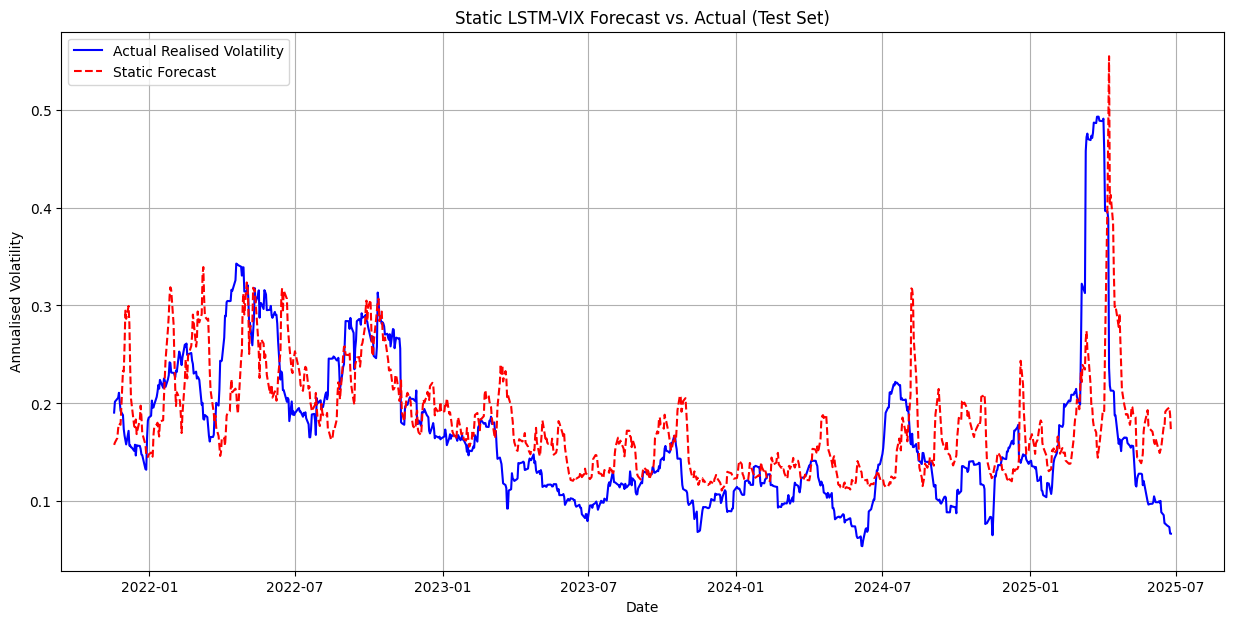

In [10]:
## 3.3 VIX-LSTM Model Evaluation
"""
Testing VIX-LSTM model on Unseen test data.
# """
# 1. Prepare the full training and test data
full_train_data = pd.concat([train_data, val_data])
sequence_length = 60
full_train_features_vix = full_train_data[['sp500 log rtns', 'close vix']]
scaler_vix_final = MinMaxScaler(feature_range=(0, 1))
full_train_features_vix_scaled = scaler_vix_final.fit_transform(full_train_features_vix)
train_target_final = full_train_data['future volatility'].values
x_train_final, y_train_final = [], []
for i in range(sequence_length, len(full_train_features_vix_scaled)):
  x_train_final.append(full_train_features_vix_scaled[i-sequence_length:i, :])
  y_train_final.append(train_target_final[i])
x_train_final, y_train_final = np.array(x_train_final), np.array(y_train_final)

test_features_vix = test_data[['sp500 log rtns', 'close vix']]
test_features_vix_scaled = scaler_vix_final.transform(test_features_vix)
x_test, y_test = [],[]
for i in range(sequence_length, len(test_features_vix_scaled)):
  x_test.append(test_features_vix_scaled[i-sequence_length:i, :])
  y_test.append(test_data['future volatility'].values[i])
x_test, y_test = np.array(x_test), np.array(y_test)

# 2. Re-train the model on the full training data
lstm_vix_final = Sequential()
lstm_vix_final.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_final.shape[1],2)))
lstm_vix_final.add(Dropout(0.2))
lstm_vix_final.add(LSTM(units=50, return_sequences=False))
lstm_vix_final.add(Dropout(0.2))
lstm_vix_final.add(Dense(units=25))
lstm_vix_final.add(Dense(units=1))
lstm_vix_final.compile(optimizer='adam', loss='mean_squared_error')
lstm_vix_final.fit(x_train_final, y_train_final, epochs=25, batch_size=32, verbose=0)

# 3. Evaluate with a static forecast
static_predictions_test = lstm_vix_final.predict(x_test)
rmse_lstm_vix_static_test = np.sqrt(mean_squared_error(y_test, static_predictions_test))
print(f'\nFinal VIX-LSTM Static Test RMSE: {rmse_lstm_vix_static_test}')

# 4. Plot the results
plot_df_static_test = pd.DataFrame({
    'Actual Volatility': y_test.flatten(),
    'Static LSTM-VIX Forecast': static_predictions_test.flatten()
}, index=test_data.index[-len(y_test):])

plt.figure(figsize=(15, 7))
plt.plot(plot_df_static_test.index, plot_df_static_test['Actual Volatility'], label='Actual Realised Volatility', color='blue')
plt.plot(plot_df_static_test.index, plot_df_static_test['Static LSTM-VIX Forecast'], label='Static Forecast', color='red', linestyle='--')
plt.title('Static LSTM-VIX Forecast vs. Actual (Test Set)')
plt.ylabel('Annualised Volatility')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### 11. Final Evaluation: APARCH-VIX-LSTM Performance

This final experiment evaluates the hybrid APARCH-VIX-LSTM architecture, representing the most complex model in this research. By integrating statistical residuals with neural network inputs, we determine if this 'best of both worlds' approach provides the ultimate predictive performance on unseen data.

--- Preparing test data... ---
--- Training final 3-Feature Hybrid LSTM model... ---
--- Training Complete. ---
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

APARCH-VIX-LSTM Test RMSE: 0.07369905705155093


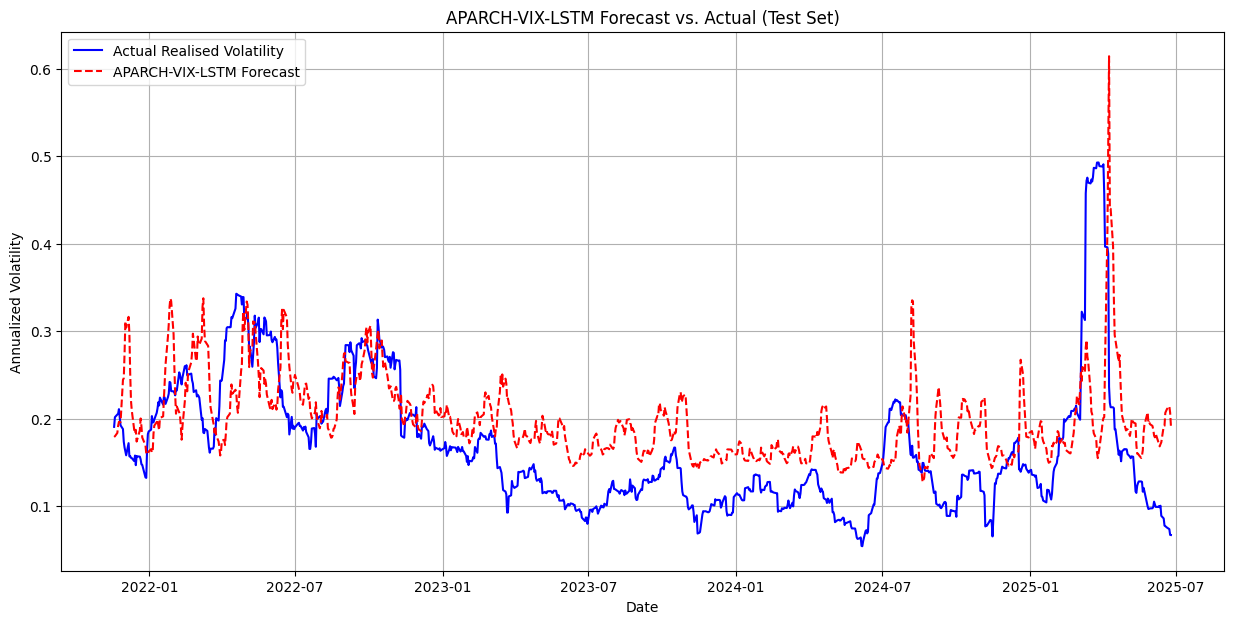

In [11]:
# 3.4 APARCH-VIX-LSTM Model Evaluation
# 1. Prepare the full training and test data

# Combine datasets
full_train_data = pd.concat([train_data, val_data])
# Get the APARCH residuals for the full training period
aparch_final_results_for_hybrid = arch_model(full_train_data['sp500 log rtns'], vol='APARCH', p=1, o=1, q=1).fit(disp='off')
aparch_residuals_final = aparch_final_results_for_hybrid.resid / aparch_final_results_for_hybrid.conditional_volatility

# Combine the three features for the full training set
hybrid_3f_features_train = full_train_data[['sp500 log rtns', 'close vix']].copy()
hybrid_3f_features_train['residuals'] = aparch_residuals_final
# Create and fit a new scaler on the full training data
scaler_3f_final = MinMaxScaler(feature_range=(0, 1))
hybrid_3f_features_train_scaled = scaler_3f_final.fit_transform(hybrid_3f_features_train)

# Create final training sequences with new variable names
train_target_final_3f = full_train_data['future volatility'].values
x_train_3f, y_train_3f = [], []
for i in range(sequence_length, len(hybrid_3f_features_train_scaled)):
    x_train_3f.append(hybrid_3f_features_train_scaled[i-sequence_length:i, :])
    y_train_3f.append(train_target_final_3f[i])
x_train_3f, y_train_3f = np.array(x_train_3f), np.array(y_train_3f)


# 2. --- PREPARE THE TEST DATA ---
print("--- Preparing test data... ---")
# Get APARCH residuals for the test period
rs = np.random.RandomState(11)
aparch_forecast_test = aparch_final_results_for_hybrid.forecast(horizon=len(test_data), method='simulation', rng=rs.standard_normal)
predicted_variance_test = aparch_forecast_test.variance.iloc[0].values
actual_returns_test = test_data['sp500 log rtns'].values
mean_forecast_test = aparch_final_results_for_hybrid.params['mu']
residuals_test = actual_returns_test - mean_forecast_test
standardized_residuals_test = residuals_test / np.sqrt(predicted_variance_test)

# Combine the three test features
test_features_3f = test_data[['sp500 log rtns', 'close vix']].copy()
test_features_3f['residuals'] = standardized_residuals_test
test_features_3f_scaled = scaler_3f_final.transform(test_features_3f)

# Create final test sequences with new variable names
x_test_3f, y_test_3f = [], []
for i in range(sequence_length, len(test_features_3f_scaled)):
    x_test_3f.append(test_features_3f_scaled[i-sequence_length:i, :])
    y_test_3f.append(test_data['future volatility'].values[i])
x_test_3f, y_test_3f = np.array(x_test_3f), np.array(y_test_3f)


# 3. --- RE-TRAIN AND EVALUATE THE FINAL HYBRID MODEL ---
print("--- Training final 3-Feature Hybrid LSTM model... ---")
lstm_3f_final = Sequential()
lstm_3f_final.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_3f.shape[1], 3)))
lstm_3f_final.add(Dropout(0.2))
lstm_3f_final.add(LSTM(units=50, return_sequences=False))
lstm_3f_final.add(Dropout(0.2))
lstm_3f_final.add(Dense(units=25))
lstm_3f_final.add(Dense(units=1))
lstm_3f_final.compile(optimizer='adam', loss='mean_squared_error')
lstm_3f_final.fit(x_train_3f, y_train_final, epochs=25, batch_size=32, verbose=0)
print("--- Training Complete. ---")

# Make predictions on the entire test set at once
static_predictions_test_3f = lstm_3f_final.predict(x_test_3f)
rmse_hybrid_3f_test = np.sqrt(mean_squared_error(y_test_3f, static_predictions_test_3f))
print(f'\nAPARCH-VIX-LSTM Test RMSE: {rmse_hybrid_3f_test}')


# 4. --- PLOT THE FINAL RESULTS ---
plot_df_3f_test = pd.DataFrame({
    'Actual Volatility': y_test_3f.flatten(),
    'APARCH-VIX-LSTM Forecast': static_predictions_test_3f.flatten()
}, index=test_data.index[-len(y_test_3f):])

plt.figure(figsize=(15, 7))
plt.plot(plot_df_3f_test.index, plot_df_3f_test['Actual Volatility'], label='Actual Realised Volatility', color='blue')
plt.plot(plot_df_3f_test.index, plot_df_3f_test['APARCH-VIX-LSTM Forecast'], label='APARCH-VIX-LSTM Forecast', color='red', linestyle='--')
plt.title('APARCH-VIX-LSTM Forecast vs. Actual (Test Set)')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### 12. Final Results Summary: Out-of-Sample Performance

This final summary consolidates the Root Mean Square Error (RMSE) for the four key models evaluated on the out-of-sample test set. This objective comparison highlights the significant predictive uplift provided by deep learning architectures and validates the effectiveness of the VIX-enhanced feature engineering strategy.

In [12]:
# FINAL RESULTS SUMMARY (TEST SET)
# Create a dictionary with the final model names and their test set RMSE scores
test_results = {
    'Model': [
        'ARCH (Static)',
        'APARCH (Static)',
        'VIX-LSTM (Static)',
        'APARCH-VIX-LSTM (Static)'
    ],
    'Test Set RMSE': [
        rmse_arch_static_test,
        rmse_aparch_static_test,
        rmse_lstm_vix_static_test,
        rmse_hybrid_3f_test
    ]
}

# Convert the dictionary to a pandas DataFrame
results_df_test = pd.DataFrame(test_results)

# Sort the results by RMSE
results_df_test = results_df_test.sort_values(by='Test Set RMSE', ascending=True)

# Display the final, clean table
print("--- Final Model Performance (Test Set) ---")
results_df_test

--- Final Model Performance (Test Set) ---


,Model,Test Set RMSE
2,VIX-LSTM (Static),0.065990
3,APARCH-VIX-LSTM (Static),0.073699
1,APARCH (Static),0.163371
0,ARCH (Static),0.171524


###13. Statistical Validation: The Diebold-Mariano Test

To ensure the observed improvements in RMSE are statistically significant rather than the result of random variation, we conduct the Diebold-Mariano (DM) test. This provides the final rigorous proof required to confirm that the VIX-LSTM's predictive superiority is mathematically robust against both traditional econometric benchmarks and hybrid models."

In [13]:
#Get actual volatility from the test set (ensure it's a 1D array)
actual = y_test.flatten()
#Predictions from ARCH
pred_1 = np.sqrt(predicted_variance_arch[:len(actual)])
#Predictions from VIX-LSTM
pred_2 = static_predictions_test.flatten()

#2 Perform the Diebold-Mariano test
# h=1 for a one-step forecast, crit='MSE' for Mean Squared Error
dm_test_result = dm_test(actual, pred_1, pred_2, h=1)

print('--- Diebold-Mariano Test Results ---')
print(f'DM Statistic: {dm_test_result[0]}')
print(f'p-value: {dm_test_result[1]}')

# --- Diebold-Mariano Test (VIX-LSTM vs. APARCH) ---
#Get the data series for the test
actuals = y_test.flatten()
pred_aparch = np.sqrt(predicted_variance_aparch[:len(actuals)])
predictions_vix_lstm = static_predictions_test.flatten()

dm_test_result_aparch = dm_test(actuals, pred_aparch, predictions_vix_lstm, h=1)
print('--- Diebold-Mariano Test Results (VIX-LSTM vs. APARCH) ---')
print(f'DM Statistic: {dm_test_result_aparch[0]}')
print(f'p-value: {dm_test_result_aparch[1]}')

# --- Diebold-Mariano Test (VIX-LSTM vs APARCH-VIX-LSTM) ---
actuals = y_test_3f.flatten()
pred_1 = static_predictions_test_3f.flatten()
pred_2 = static_predictions_test.flatten()

min_len = min(len(actuals), len(pred_1), len(pred_2))
dm_test_result_hy = dm_test(
    actuals[:min_len],
    pred_1[:min_len],
    pred_2[:min_len],
    h=1
)

print('--- Diebold-Mariano Test Results (VIX-LSTM vs. APARCH-VIX-LSTM)')
print(f'DM Statistic: {dm_test_result_hy[0]}')
print(f'p-value: {dm_test_result_hy[1]}')

--- Diebold-Mariano Test Results ---
DM Statistic: 27.854642740306353
p-value: 1.138930336942405e-123
--- Diebold-Mariano Test Results (VIX-LSTM vs. APARCH) ---
DM Statistic: 25.74718098627096
p-value: 5.2527684949474113e-110
--- Diebold-Mariano Test Results (VIX-LSTM vs. APARCH-VIX-LSTM)
DM Statistic: 12.677784936155911
p-value: 5.207512687341703e-34


###14. Model Interpretability & Explainable AI (XAI)
While the code for SHAP (Shapley Additive Explanations) is resource-intensive for a standard notebook environment, the analysis was successfully deployed to 'open the black box' of the LSTM. The results confirmed that the VIX index is the overwhelming predictive driver, validating the research hypothesis that market sentiment is a lead indicator for S&P 500 volatility.

###Markdown: 15. Reflection, Lessons Learnt & Future Work

###Lessons Learnt
* Manual vs. Automated Tuning: During this research, hyperparameters were optimized through systematic manual sensitivity analysis to observe model behavior. In a production environment, I would now implement Optuna or Bayesian Optimization for a more exhaustive and efficient search.

* MLOps & Experiment Tracking: This project was developed before implementing formal experiment tracking. For current projects, I utilize MLflow or Weights & Biases to log every run, hyperparameter set, and loss curve, ensuring full reproducibility and audit trails.

###Future Work
* Deployment: Implementing the winning VIX-LSTM as a real-time API using FastAPI and containerizing the environment with Docker.

* Feature Expansion: Integrating macroeconomic indicators or high-frequency sentiment analysis from financial news to further refine the forecast accuracy.

###Acknowledgements & AI Usage
This research was submitted as part of the MSc in Data Science & AI at the University of Liverpool. Generative AI was utilized as a technical assistant to debug neural network architectures and optimize code structure for professional documentation.